<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [156]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import itertools
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn import metrics
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [157]:
# Load the data
house = pd.read_csv('./housing.csv')

In [158]:
house.shape

(1460, 81)

In [159]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [160]:
# Drop ID column
house = house.drop('Id', axis=1)

Remove non-residential houses

In [161]:
pd.get_dummies(house['MSZoning'])

,C (all),FV,RH,RL,RM
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
5,0,0,0,1,0
6,0,0,0,1,0
7,0,0,0,1,0
8,0,0,0,0,1
9,0,0,0,1,0


Since only C (all) is non-residential, we shall say See Yall to C (all)

In [162]:
house = house[house.MSZoning != 'C (all)']
house.shape

(1450, 80)

In [163]:
house.isnull().sum().sort_values(ascending=False)[0:21]

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageType        79
GarageCond        79
GarageFinish      79
GarageQual        79
GarageYrBlt       79
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
Exterior1st        0
dtype: int64

From above, the top 5 missing values' data labels are null for more than 40-50% of total number (1450). Let's remove these columns!

In [164]:
house = house.drop('PoolQC',axis=1)

In [165]:
house = house.drop('MiscFeature',axis=1)

In [166]:
house = house.drop('Alley',axis=1)

In [167]:
house = house.drop('Fence',axis=1)

In [168]:
house = house.drop('FireplaceQu',axis=1)

In [169]:
house.isnull().sum().sort_values(ascending=False)[0:15]

LotFrontage     259
GarageType       79
GarageYrBlt      79
GarageCond       79
GarageQual       79
GarageFinish     79
BsmtExposure     38
BsmtFinType2     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrArea        8
MasVnrType        8
Electrical        1
Exterior1st       0
dtype: int64

In [170]:
house.Electrical.value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Since SBrkr accounts for most of the Electrical data, it is reasonable to assume null value as SBrkr.

In [171]:
house.loc[house['Electrical'].isnull(),'Electrical'] = 'SBrkr'
house.Electrical.value_counts()

SBrkr    1329
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [172]:
house.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
                  ...   
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object


In [173]:
house.isnull().sum().sort_values(ascending=False)[0:14]

LotFrontage     259
GarageType       79
GarageYrBlt      79
GarageFinish     79
GarageQual       79
GarageCond       79
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrType        8
MasVnrArea        8
YearBuilt         0
dtype: int64

In [174]:
for col in house.columns[house.isnull().sum() > 0]:
        house[col] = house[col].fillna(int(0))
        print house[col].value_counts()

0.0      259
60.0     139
70.0      70
80.0      69
50.0      55
75.0      53
65.0      44
85.0      40
78.0      25
21.0      23
90.0      23
68.0      19
24.0      19
64.0      19
73.0      18
72.0      17
79.0      17
63.0      17
55.0      17
100.0     16
51.0      15
74.0      15
52.0      14
66.0      13
59.0      13
67.0      12
57.0      12
40.0      12
71.0      12
43.0      12
        ... 
134.0      2
101.0      2
109.0      2
97.0       2
124.0      2
121.0      2
122.0      2
115.0      2
114.0      2
118.0      2
153.0      1
182.0      1
140.0      1
138.0      1
38.0       1
111.0      1
150.0      1
106.0      1
39.0       1
46.0       1
144.0      1
149.0      1
128.0      1
168.0      1
112.0      1
160.0      1
141.0      1
33.0       1
152.0      1
137.0      1
Name: LotFrontage, Length: 111, dtype: int64
None       854
BrkFace    445
Stone      128
BrkCmn      15
0            8
Name: MasVnrType, dtype: int64
0.0       859
72.0        8
180.0       8
108.0       8


In [175]:
house.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
                  ...   
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object


In [176]:
house.isnull().sum().sort_values(ascending=False)[0:14]

SalePrice       0
YearRemodAdd    0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
ExterQual       0
ExterCond       0
Foundation      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
dtype: int64

### Data is relatively 'clean', shall use correlation to spot highly correlated features wrt to Sale Price

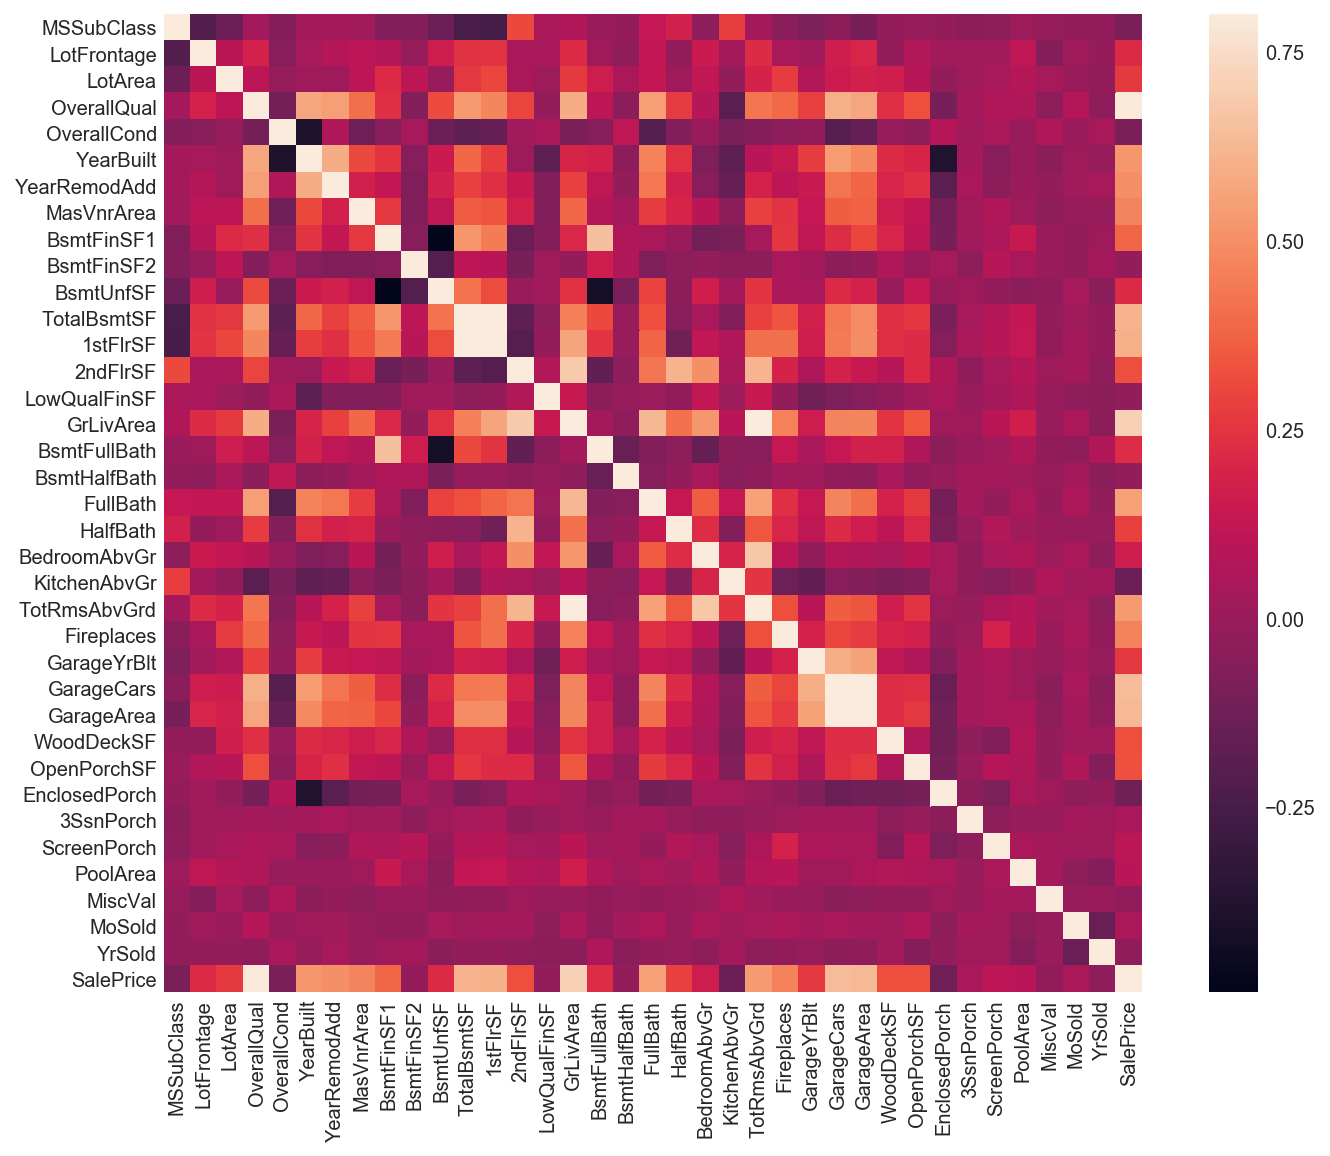

In [177]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(house.corr(), vmax=0.8, square=True);

Fixed features shall be GrLivArea and GarageArea

In [178]:
print house.SalePrice
print house.GrLivArea
print house.GarageArea

0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1450, dtype: int64
0       1710
1       1262
2       1786
3 

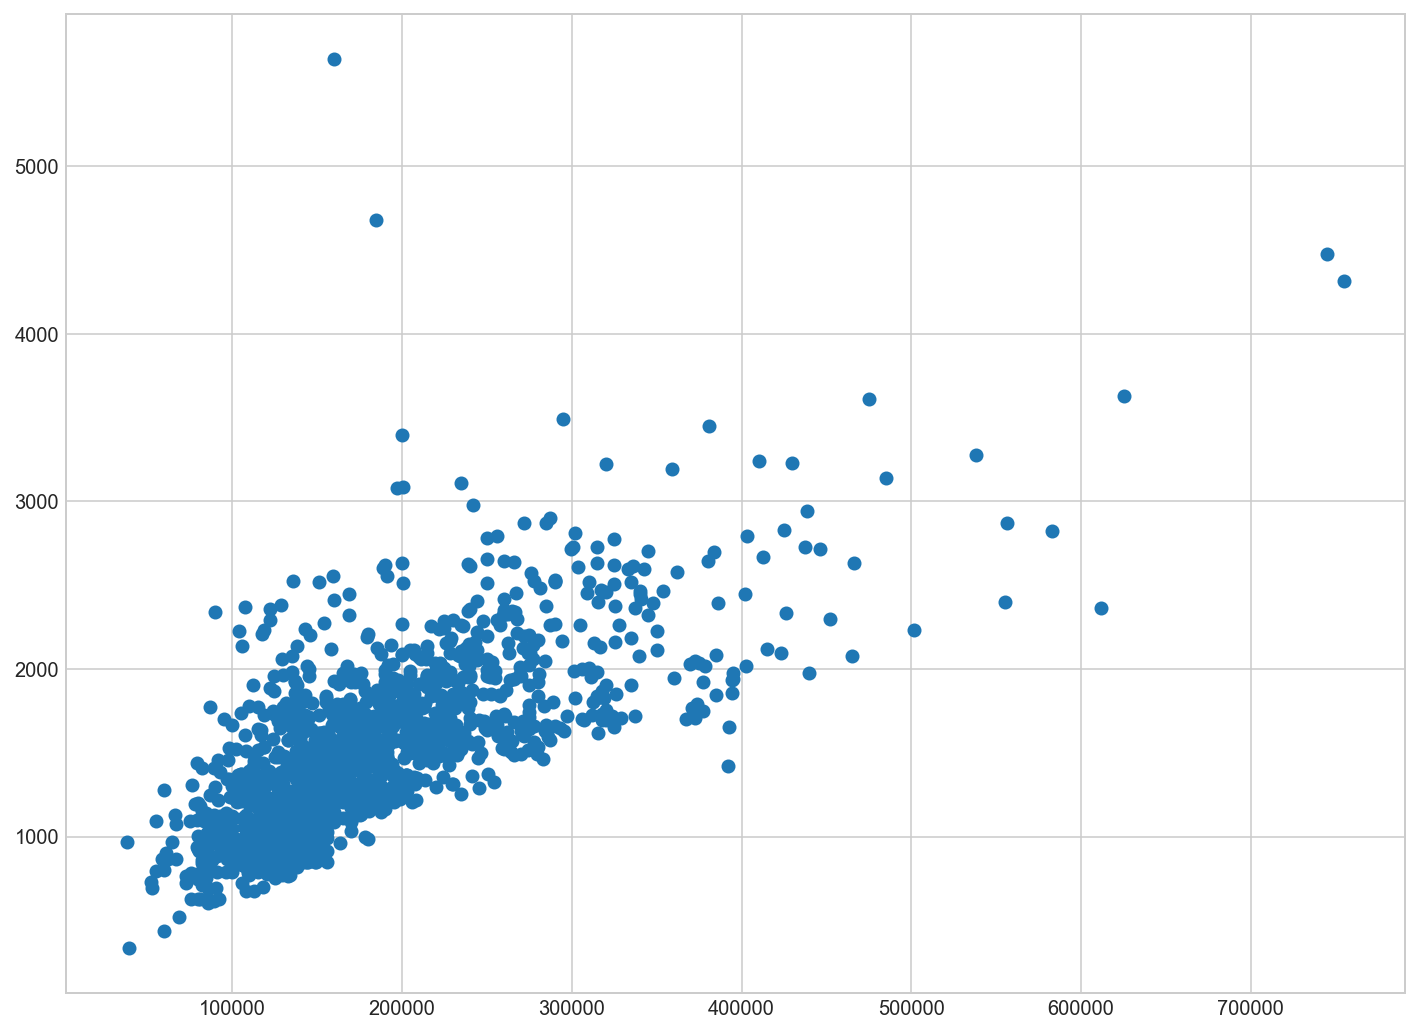

In [179]:
f, ax = plt.subplots(figsize=(12, 9))
plt.scatter(house.SalePrice, house.GrLivArea);

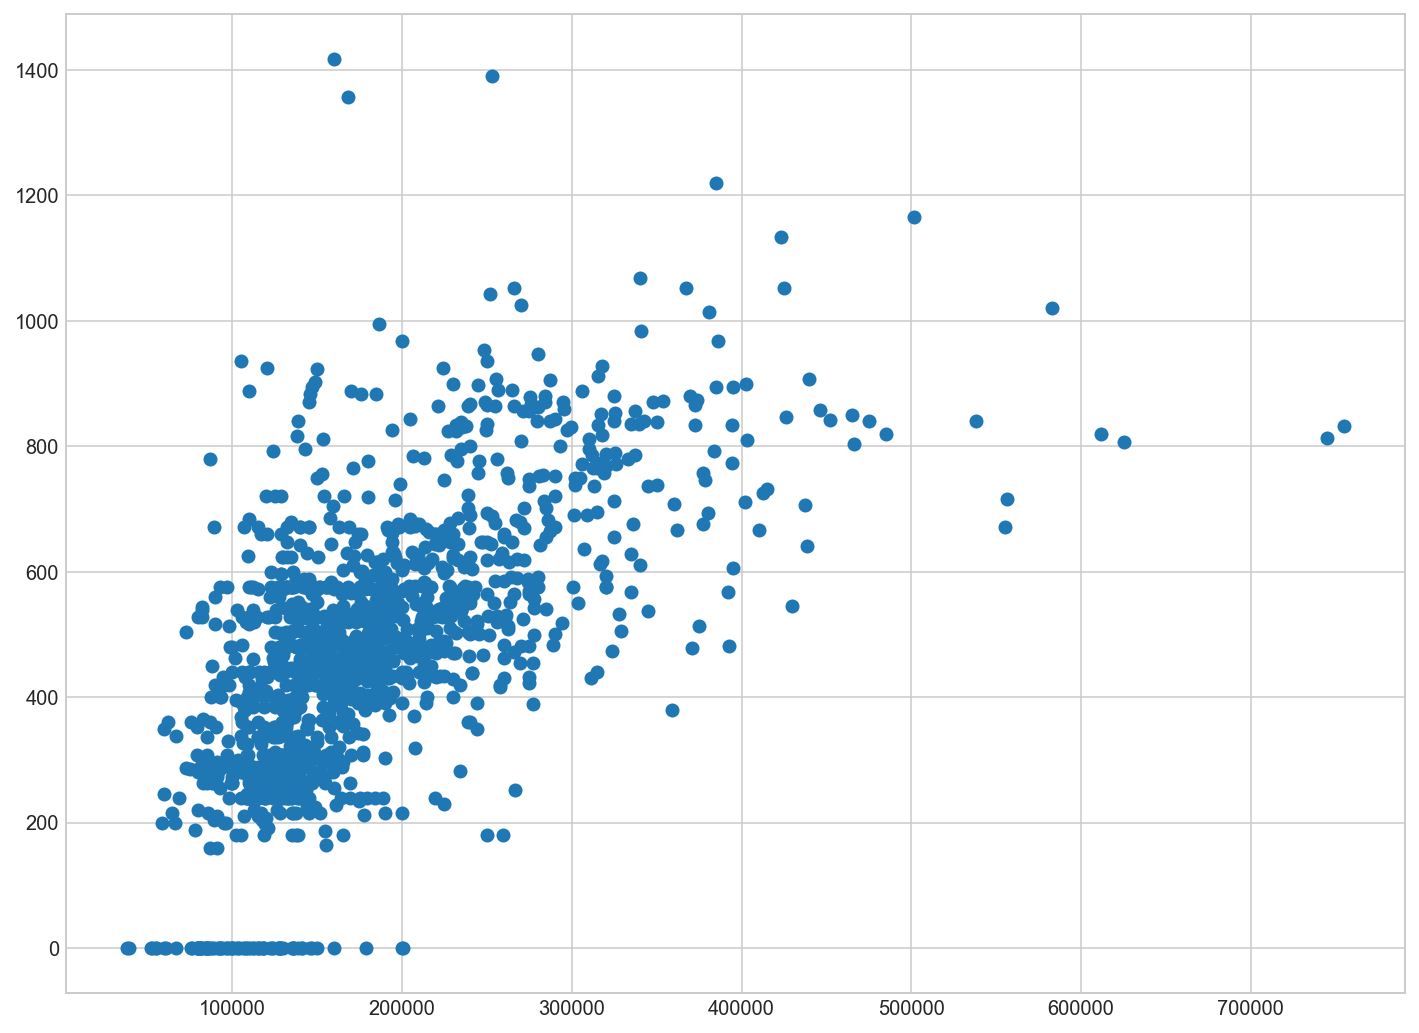

In [180]:
f, ax = plt.subplots(figsize=(12, 9))
plt.scatter(house.SalePrice, house.GarageArea);

Before assigning my X and y, split the data into train and test sections. Train section will contain pre-2010 sales and test section will contain 2010 sales.

In [181]:
house.YrSold.value_counts()

2009    336
2007    328
2006    312
2008    302
2010    172
Name: YrSold, dtype: int64

In [182]:
# Sort df by year of sale
house = house.sort_values(by='YrSold').reset_index(drop=True)
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,30,RL,60.0,10800,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,120000
1,60,FV,84.0,10728,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2006,New,Partial,266000
2,160,FV,30.0,3180,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,151000
3,60,RL,70.0,11207,Pave,IR1,HLS,AllPub,FR2,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,185000
4,90,RL,70.0,7728,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2006,WD,Normal,132500


In [183]:
#Look at first row where 2010 starts:
house[house.YrSold == 2010].index[0]

1278

In [184]:
fix_feat = '~  GarageArea + GrLivArea + -1'

In [185]:
X = patsy.dmatrix(fix_feat, data=house, return_type='dataframe')
X = X.drop(columns=['Intercept'])
y = house.SalePrice

print X.shape
print y.shape

(1450, 2)
(1450,)


In [186]:
cols = list(house.columns)

In [187]:
X_train = X.iloc[:1278,]
y_train = y.iloc[:1278,]

print X_train.shape
print y_train.shape

(1278, 2)
(1278,)


In [188]:
X_test = X.iloc[1278:,]
y_test = y.iloc[1278:,]

print X_test.shape
print y_test.shape

(172, 2)
(172,)


In [189]:
lm = LinearRegression()

model = lm.fit(X_train, y_train)
print model.score(X_train, y_train) 

0.6119624421917299


0.6231416430102833


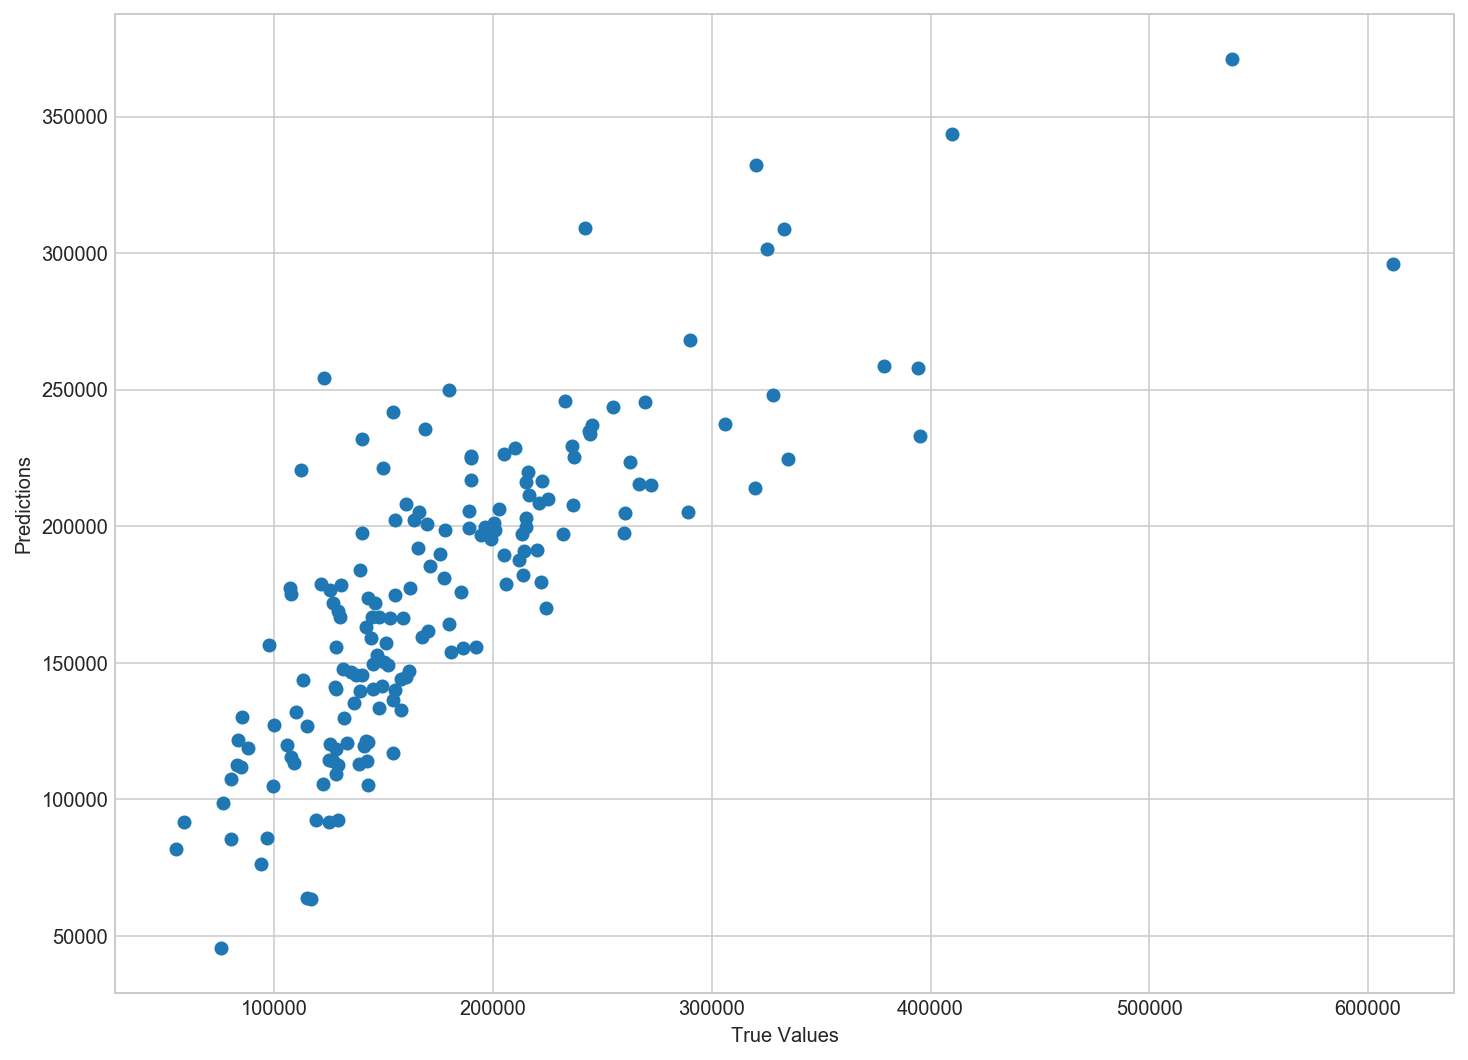

In [190]:
y_pred = lm.predict(X_test)

# Plot the model
f, ax = plt.subplots(figsize=(12, 9))
plt.scatter(y_test, y_pred)

plt.xlabel("True Values")
plt.ylabel("Predictions")

print model.score(X_test, y_test)

In [191]:
print r2_score(y_test, y_pred)

0.6231416430102833


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [192]:
#Get residuals
train_resid = y_train - lm.predict(X_train)
print train_resid.shape
# all pre 2010 data

test_resid = y_test - y_pred
print test_resid.shape
# 2010 data

lm_residuals = train_resid
print lm_residuals.shape

lm_residuals = lm_residuals.append(test_resid)
print lm_residuals.shape
#lm_residuals

(1278,)
(172,)
(1278,)
(1450,)


In [193]:
house["lm_residuals"] = lm_residuals

In [194]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,lm_residuals
0,30,RL,60.0,10800,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,6,2006,WD,Normal,120000,-64943.576159
1,60,FV,84.0,10728,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,8,2006,New,Partial,266000,-28983.885477
2,160,FV,30.0,3180,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,6,2006,WD,Normal,151000,-6135.000465
3,60,RL,70.0,11207,Pave,IR1,HLS,AllPub,FR2,Gtl,...,0,0,0,0,6,2006,WD,Normal,185000,12644.178805
4,90,RL,70.0,7728,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,5,2006,WD,Normal,132500,-32178.585226


In [196]:
changeable_features = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 
                       'BsmtFinType2', 'HeatingQC', 'CentralAir','KitchenQual', 'Functional', 'GarageQual',
                       'GarageCond']
len(changeable_features)

14

In [198]:
#Setting up patsy matrix and target:
changeable_feat = '~ OverallQual + OverallCond + ExterQual + ExterCond + BsmtQual + BsmtCond + BsmtFinType1 + BsmtFinType2 + HeatingQC + CentralAir + KitchenQual + Functional + GarageQual + GarageCond + -1'

X_r = patsy.dmatrix(changeable_feat, data=house, return_type='dataframe')
y_r = house.lm_residuals

print X_r.shape
print y_r.shape

(1450, 54)
(1450,)


In [199]:
#Standardize X matrix:
ss = StandardScaler()
X_rn = ss.fit_transform(X_r)

In [200]:
# #Prepare a range of alpha values to test
# alphas = np.logspace(-10,10,21)

# #Create a dictionary with the gridsearch parameters
# params = {'alpha': alphas}

# #Create and Fit a Ridge Regression Model, Testing Each Alpha
# model = Ridge( )
# grid = GridSearchCV(estimator=model, param_grid=params)
# grid.fit(X_rn,y)

# print "Grid:\n", grid
# print 
# #Summarize the Results of the Grid Search
# print "Best score:\n", grid.best_score_
# print "Best estimator alpha: \n", grid.best_estimator_.alpha

In [201]:
#Ridge using best estimator:

ridge = Ridge(alpha=100)

ridge_scores = cross_val_score(ridge, X_rn, y, cv=5)

print ridge_scores
print np.mean(ridge_scores)

[0.71440708 0.65760218 0.65401568 0.70808736 0.7181206 ]
0.6904465805833094


In [202]:
ridge.fit(X_rn, y)

ridge_coefs = pd.DataFrame({'variable':X_r.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs.head(20)

,abs_coef,coef,variable
52,35756.795328,35756.795328,OverallQual
35,16202.115233,-16202.115233,KitchenQual[T.TA]
8,15286.159085,15286.159085,BsmtQual[T.Ex]
3,13008.492643,-13008.492643,ExterQual[T.TA]
34,11389.635112,-11389.635112,KitchenQual[T.Gd]
2,6148.049123,-6148.049123,ExterQual[T.Gd]
42,5865.469496,5865.469496,GarageQual[T.Ex]
11,5515.719593,-5515.719593,BsmtQual[T.TA]
47,5102.930216,-5102.930216,GarageCond[T.Ex]
21,4483.071323,-4483.071323,BsmtFinType1[T.Unf]


We can see that in order of descending importance: Overall quality of the house, Basement, Kitchen and Exterior qualities.

The two models can help to shed light on how the company can invest their money based on type, size and location of the building and also which are the easily reparable features that can give them the best return of investment.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [181]:
house.SaleCondition.value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

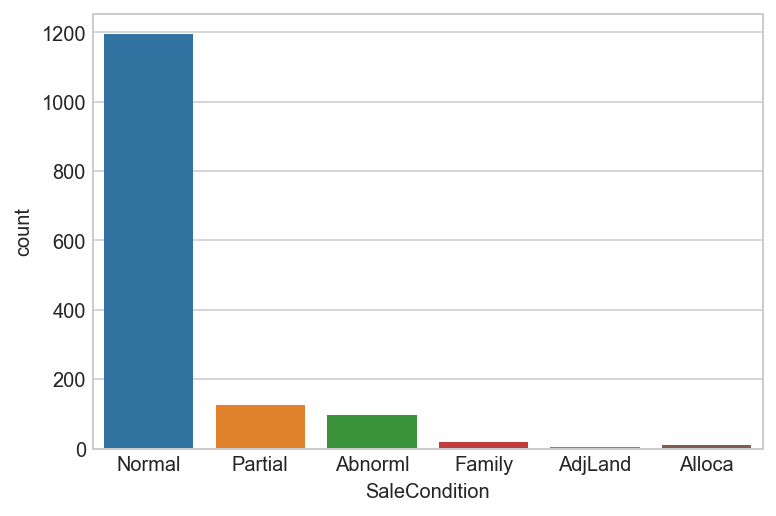

In [184]:
sns.countplot(house.SaleCondition)
plt.show()

Since there is a huge imbalance, we are recommended to "do some research to find out how others have dealt with the problem in the past". After intense research and literature reviews done over a long period (read: 2 short articles over 5mins), elitedatascience.com's article on imbalanced classes has a few suggestions, which include up-sampling minority class and down-sampling majority class. Personally, I prefer down-sampling majority class as it is better to reduce the size of 'Normal' than to increase the size of minority, which will amplify any inherent errors.

From the "Normal" and "Partial" classes I'm going to randomly pick 100 samples each and proceed with classification. I'm also going to merge 3 least common classes into one, called "Other".

In [185]:
# Add minority classes to a new dataframe
minority_house = house[(house["SaleCondition"] == "Abnorml")
                        | (house["SaleCondition"] == "AdjLand")
                        | (house["SaleCondition"] == "Family")
                        | (house["SaleCondition"] == "Alloca")
                      ]

In [186]:
minority_house.shape

(131, 76)

In [187]:
#Replacing small classes name with "Other":
minority_house.loc[:,'SaleCondition'] = minority_house.SaleCondition.map(lambda x: "Other" if x == "Family" else x) 
minority_house.loc[:,'SaleCondition'] = minority_house.SaleCondition.map(lambda x: "Other" if x == 'Alloca' else x)
minority_house.loc[:,'SaleCondition'] = minority_house.SaleCondition.map(lambda x: "Other" if x == 'AdjLand' else x)

/Users/jjwoo/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [188]:
minority_house.SaleCondition.value_counts()

Abnorml    96
Other      35
Name: SaleCondition, dtype: int64

In [189]:
#Adding sample of 100 "Normal" and "Partial" sales to the new df
minority_house = minority_house.append(house[house["SaleCondition"] == "Normal"].sample(n=100, replace=False, random_state=40))
minority_house = minority_house.append(house[house["SaleCondition"] == "Partial"].sample(n=100, replace=False, random_state=40))

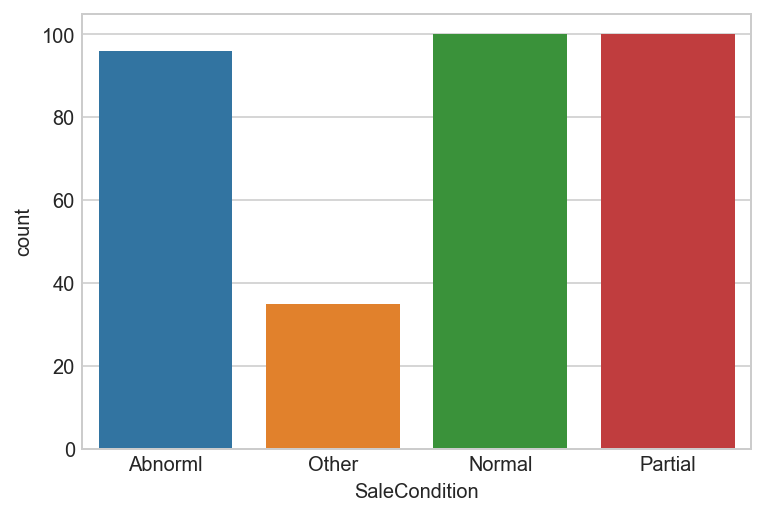

In [190]:
sns.countplot(minority_house.SaleCondition)
plt.show()